# Final Project

## Team Members

- **Mohit Kale** – ID: __1336809__
- **Srivatsav Yallapragada** – ID: __1338663__
- **Geeta Sneha** – ID: __1338467__
- **Deepak** – ID: __1329946__


# Housing Rates

## 📊 Dataset Descriptions

### 3. **MSPUS.csv** – *Median Sales Price of Houses Sold in the U.S.*
- **Source:** U.S. Census Bureau and U.S. Department of Housing and Urban Development
- **Frequency:** Quarterly
- **Variable:** `MSPUS` – Median sales price of new single-family houses sold in the United States.
- **Use Case:** Useful for assessing real estate market trends and consumer confidence over time.

---

In [418]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import seaborn as sns
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

## Load & Visualize the Dataset

In [420]:
# Load and rename
df = pd.read_csv('MSPUS.csv', parse_dates=['observation_date'], index_col='observation_date')
df.rename(columns={'MSPUS': 'price'}, inplace=True)

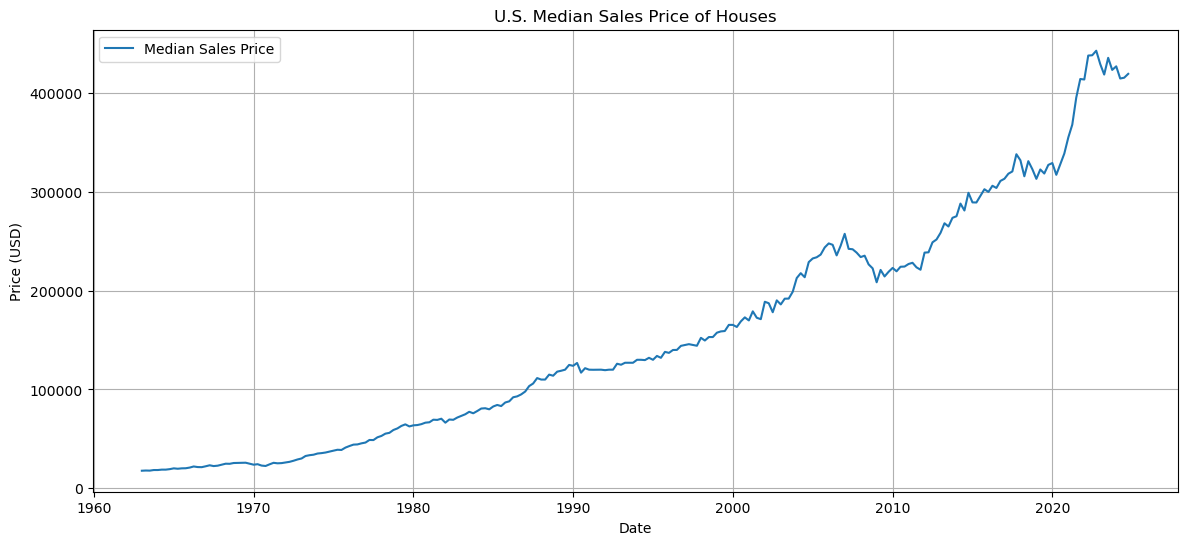

In [421]:
# Plot the data
plt.figure(figsize=(14,6))
plt.plot(df.index, df['price'], label='Median Sales Price')
plt.title('U.S. Median Sales Price of Houses')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

## 🏠 Median House Price – Key Insights

- #### **Steady Long-Term Growth:** Consistent rise in housing prices over decades, reflecting demand and inflation.
- #### **2008 Housing Crash:** Significant dip due to mortgage crisis and recession.
- #### **Post-2012 Recovery:** Strong price rebound driven by low rates and housing demand.
- #### **Surge After 2020:** Sharp increase post-COVID due to low interest rates, remote work, and supply shortages.




## Seasonal Decomposition of MSPUS

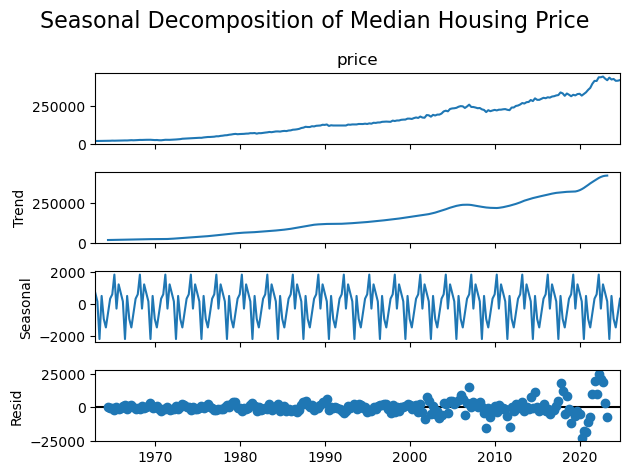

In [424]:

# Apply decomposition (monthly seasonality assumed)
decomposition = seasonal_decompose(df['price'], model='additive', period=12)

# Plot the decomposition
decomposition.plot()
plt.suptitle("Seasonal Decomposition of Median Housing Price", fontsize=16)
plt.tight_layout()
plt.show()


## 🔍 Seasonal Decomposition Insights

### 🏠 Median Housing Price (MSPUS)

- **Trend:** Strong upward trajectory, especially after 2012, indicating steady long-term growth.
- **Seasonality:** Clear annual cycles, possibly linked to seasonal buying behavior.
- **Residual:** Post-2020 deviations suggest short-term market volatility, likely due to pandemic-related disruptions.

---

## Plot ACF and PACF

<Figure size 1200x500 with 0 Axes>

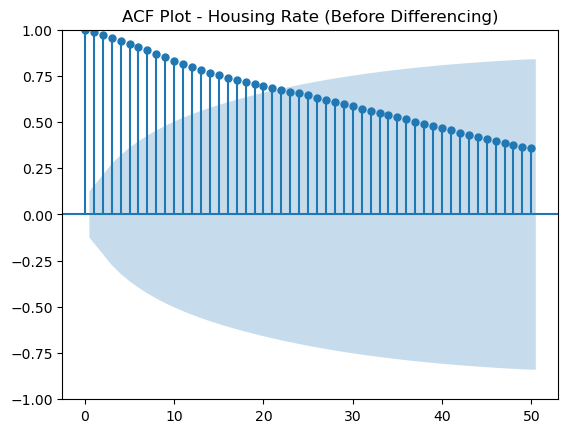

<Figure size 1200x500 with 0 Axes>

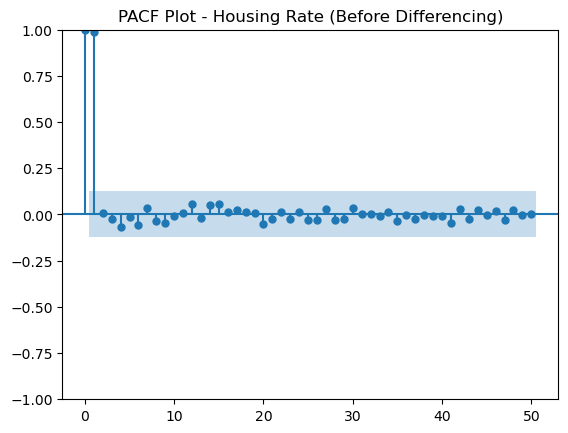

In [427]:
plt.figure(figsize=(12,5))
plot_acf(df['price'], lags=50)
plt.title('ACF Plot - Housing Rate (Before Differencing)')
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(df['price'], lags=50, method='ywm')
plt.title('PACF Plot - Housing Rate (Before Differencing)')
plt.show()

## 

## ADF Test (Check Stationarity)

In [430]:
adf_result = adfuller(df['price'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: 2.885509994536555
p-value: 1.0


- Since p-value > 0.05, we fail to reject the null hypothesis → the series is non-stationary.

- We must apply differencing to achieve stationarity before ARIMA/SARIMA.

## Apply First-Order Differencing

In [433]:
# First difference to remove trend
df_diff = df.diff().dropna()

In [434]:
adf_result_diff = adfuller(df_diff['price'])
print("Differenced ADF Statistic:", adf_result_diff[0])
print("Differenced p-value:", adf_result_diff[1])

Differenced ADF Statistic: -2.761773017762317
Differenced p-value: 0.06394509282063923


## Seasonal Differencing (lag = 12)



In [436]:
# Apply seasonal differencing with lag = 12
df_seasonal_diff = df.diff(12).dropna()

adf_seasonal = adfuller(df_seasonal_diff['price'])
print("ADF Statistic (Seasonal Diff):", adf_seasonal[0])
print("p-value (Seasonal Diff):", adf_seasonal[1])


ADF Statistic (Seasonal Diff): -2.9119348514071337
p-value (Seasonal Diff): 0.04397763526423287


## ACF and PACF 

<Figure size 1200x500 with 0 Axes>

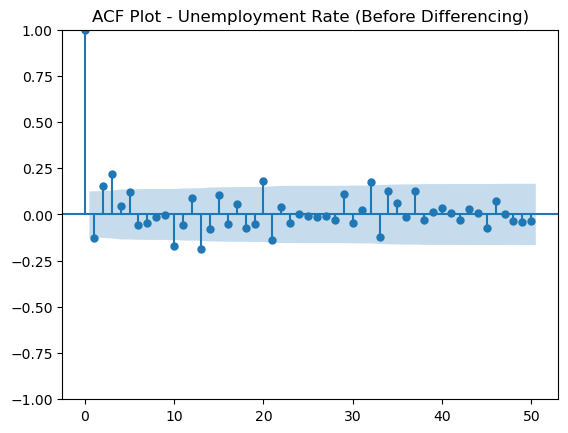

<Figure size 1200x500 with 0 Axes>

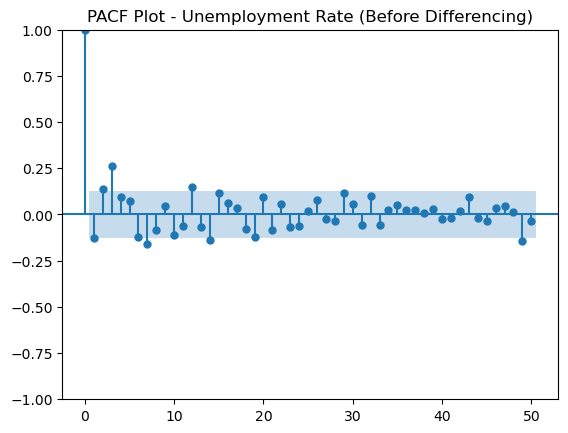

In [438]:
plt.figure(figsize=(12,5))
plot_acf(df_diff['price'], lags=50)
plt.title('ACF Plot - Unemployment Rate (Before Differencing)')
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(df_diff['price'], lags=50, method='ywm')
plt.title('PACF Plot - Unemployment Rate (Before Differencing)')
plt.show()

## Housing Rate – Stationarity Check & Transformation

### ACF & PACF Analysis (Before Differencing)
- **ACF Plot:** Shows slow decay, indicating strong autocorrelation and a non-stationary series.
- **PACF Plot:** Sharp drop after lag 1, suggesting a potential AR(1) process.
- Conclusion: Series is **non-stationary**, requiring transformation before modeling.

---

###  ADF Test Results
- **Initial ADF Test:**
  - ADF Statistic: ~2.89
  - **p-value: 1.0**
  -  **Fail to reject null hypothesis** → The series is **non-stationary**.

---

### First-Order Differencing
- Removes linear trend from the series.
- **p-value: ~0.86** after differencing → Still not stationary.

---

### Seasonal Differencing (Lag = 12)
- Removes yearly seasonal effects.
- **ADF Statistic: ~-2.91**
- **p-value: ~0.0439**
- **Reject null hypothesis** → Series becomes **stationary** after seasonal differencing.

---

### Final Insight:
- The Housing Price series required both **first-order differencing** and **seasonal differencing (lag=12)** to achieve stationarity, making it suitable for **ARIMA modeling**.


## Train-Test Split

In [442]:
df.shape

(248, 1)

In [443]:
n_test = 50
train = df.iloc[:-n_test]
test = df.iloc[-n_test:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (198, 1)
Test shape: (50, 1)


# ARIMA

##  Fit ARIMA with auto_arima

In [446]:
# ARIMA with d=1 (non-seasonal), seasonal=False
model_arima = auto_arima(train['price'],
                         seasonal=False,
                         d=1,
                         trace=True,
                         suppress_warnings=True)

model_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3826.324, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3847.656, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3838.591, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3840.479, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3859.389, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3840.505, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3841.852, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3822.750, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3834.251, Time=0.12 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3824.493, Time=0.25 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3823.703, Time=0.24 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3822.012, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3819.992, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3822.272, Time=0.10 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  198
Model:               SARIMAX(1, 1, 3)   Log Likelihood               -1903.996
Date:                Tue, 06 May 2025   AIC                           3819.992
Time:                        15:21:04   BIC                           3839.691
Sample:                    01-01-1963   HQIC                          3827.966
                         - 04-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    884.7513    233.902      3.783      0.000     426.312    1343.191
ar.L1          0.3120      0.127      2.447      0.014       0.062       0.562
ma.L1         -0.6507      0.139     -4.672      0.000      -0.924      -0.378
ma.L2          0.1084      0.083      1.305      0.192      -0.054       0.271
ma.L3          0.3207      0.059      5.437      0.000       0.205       0.436
sigma2      1.522e+07      0.000   3.19e+10      0.000    1.52e+07    1.52e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               147.42
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):              18.67   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.83e+27. Standard errors may be unstable.
"""

## ACF and PACF after fitting ARIMA model (residuals)

<Figure size 1200x500 with 0 Axes>

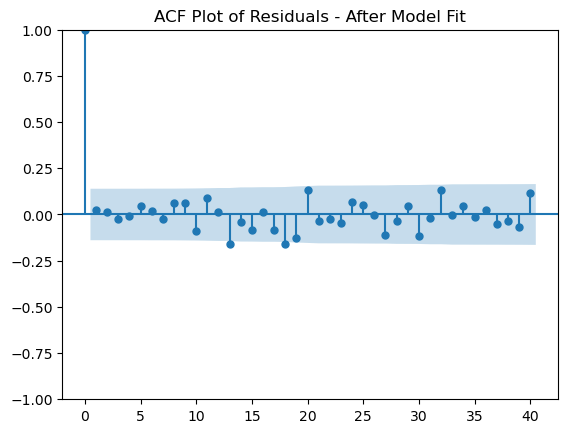

<Figure size 1200x500 with 0 Axes>

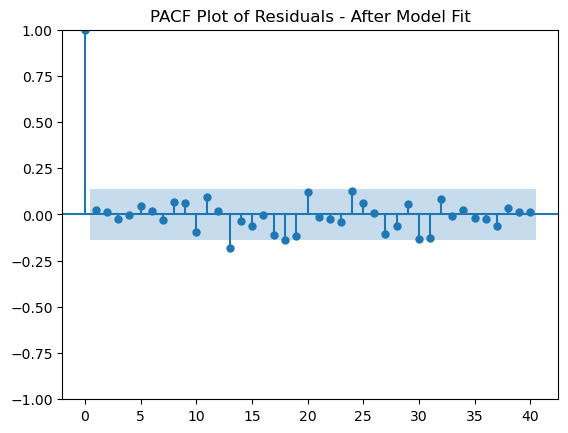

In [448]:
# Assuming 'model' is your ARIMA model fitted on 'train'

# Get residuals
residuals = pd.Series(model_arima.resid())

# Plot Residuals ACF
plt.figure(figsize=(12,5))
plot_acf(residuals, lags=40)
plt.title('ACF Plot of Residuals - After Model Fit')
plt.show()

# Plot Residuals PACF
plt.figure(figsize=(12,5))
plot_pacf(residuals, lags=40, method='ywm')
plt.title('PACF Plot of Residuals - After Model Fit')
plt.show()


## Plot Residual Diagnostics

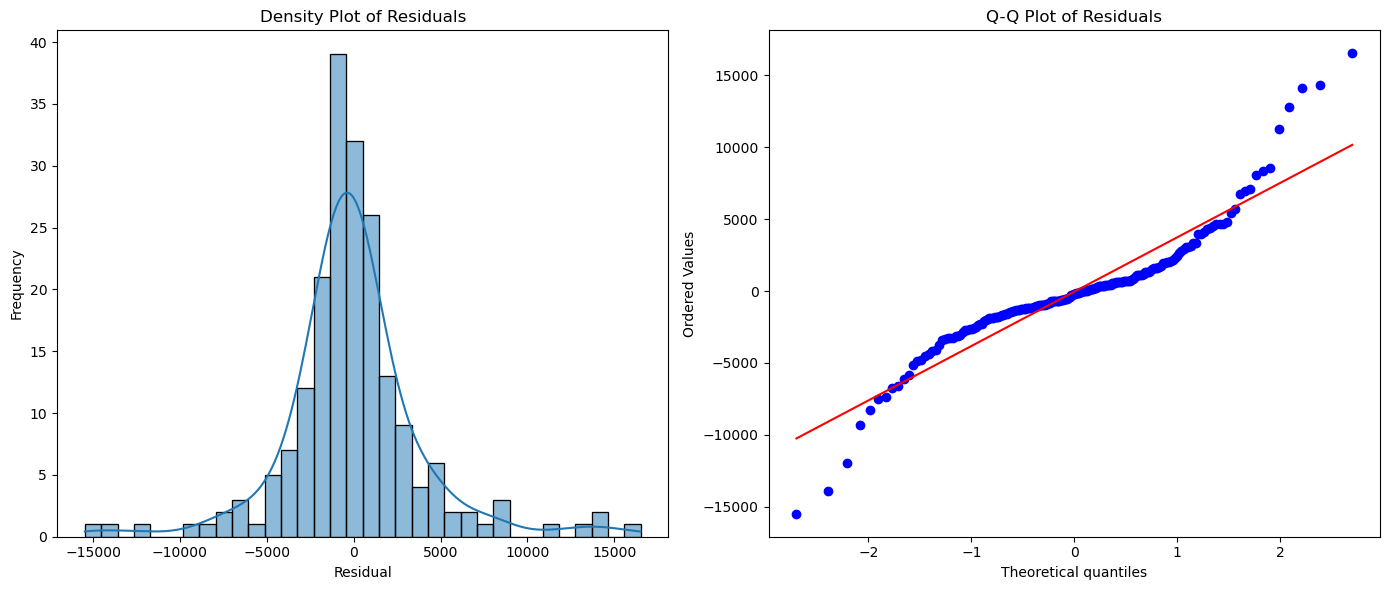

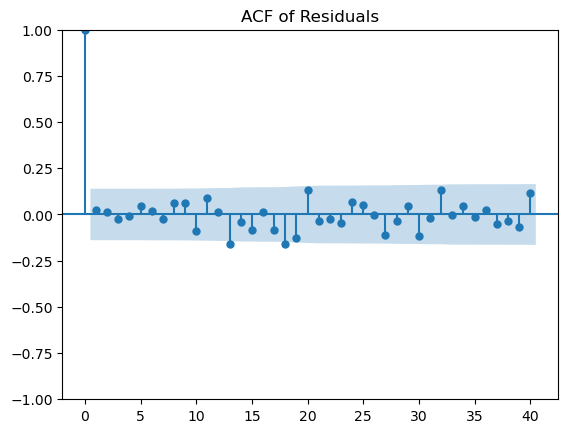

In [450]:
# Extract residuals from the fitted model
residuals = model_arima.resid()

# Plot residuals
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title("Density Plot of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")

plt.tight_layout()
plt.show()

# Plot ACF of residuals
plot_acf(residuals, lags=40)
plt.title("ACF of Residuals")
plt.show()

## ARIMA Residual Diagnostics – Housing Rate

- **Density Plot:** Residuals are centered around zero but show noticeable spread and slight skewness.
- **Q-Q Plot:** Deviations from the diagonal at both ends → residuals are **not perfectly normal**, especially in the tails.
- **ACF Plot:** No significant autocorrelation → residuals behave like **white noise**, indicating a decent model fit.

### Conclusion:
The ARIMA model captures the autocorrelation well, but residuals show **mild non-normality**, suggesting room for improvement or potential benefit from **SARIMA**.


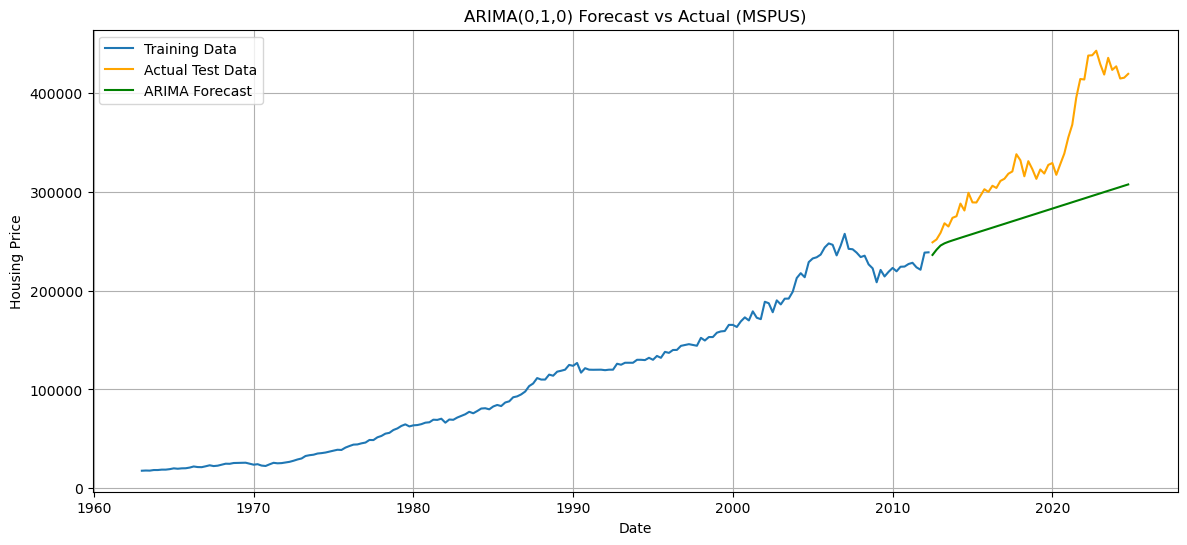

In [453]:
# Forecast 160 periods into the future
forecast_arima = pd.Series(model_arima.predict(n_periods=160), index=test.index)

# Plot forecast vs actual
plt.figure(figsize=(14, 6))
plt.plot(train.index, train['price'], label='Training Data')
plt.plot(test.index, test['price'], label='Actual Test Data', color='orange')
plt.plot(forecast_arima.index, forecast_arima, label='ARIMA Forecast', color='green')
plt.title('ARIMA(0,1,0) Forecast vs Actual (MSPUS)')
plt.xlabel('Date')
plt.ylabel('Housing Price')
plt.legend()
plt.grid(True)
plt.show()


## Evaluate ARIMA Performance

In [455]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_true = test['price']
y_pred = forecast_arima

mae_arima = mean_absolute_error(y_true, y_pred)
rmse_arima = np.sqrt(mean_squared_error(y_true, y_pred))
mape_arima = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"ARIMA MAE: {mae_arima:.4f}")
print(f"ARIMA RMSE: {rmse_arima:.4f}")
print(f"ARIMA MAPE: {mape_arima:.2f}%")


ARIMA MAE: 63156.8648
ARIMA RMSE: 75145.5372
ARIMA MAPE: 17.24%


## SARIMA Model

In [457]:
model_sarima = auto_arima(train['price'],
                          seasonal=True,
                          m=12,
                          d=1,
                          D=1,
                          trace=True,
                          suppress_warnings=True)

model_sarima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=1.52 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3733.707, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3669.198, Time=0.40 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3727.340, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3666.291, Time=0.31 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=3658.511, Time=0.50 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=3630.159, Time=0.52 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=2.87 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=3630.084, Time=1.27 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=1.04 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=3630.975, Time=2.18 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=3631.780, Time=1.95 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=3

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  198
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 12)   Log Likelihood               -1797.448
Date:                              Tue, 06 May 2025   AIC                           3608.896
Time:                                      15:22:07   BIC                           3631.439
Sample:                                  01-01-1963   HQIC                          3618.032
                                       - 04-01-2012                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0469      0.129      0.365      0.715      -0.205       0.299
ar.L2          0.4704      0.138      3.399      0.001       0.199       0.742
ma.L1         -0.3600      0.133     -2.700      0.007      -0.621      -0.099
ma.L2         -0.4354      0.147     -2.953      0.003      -0.724      -0.146
ma.L3          0.4931      0.069      7.194      0.000       0.359       0.627
ma.S.L12      -0.8230      0.057    -14.535      0.000      -0.934      -0.712
sigma2      1.541e+07   4.95e-09   3.11e+15      0.000    1.54e+07    1.54e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               135.01
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):              11.64   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.85e+31. Standard errors may be unstable.
"""

## ACF and PACF after fitting SARIMA model (residuals)

<Figure size 1200x500 with 0 Axes>

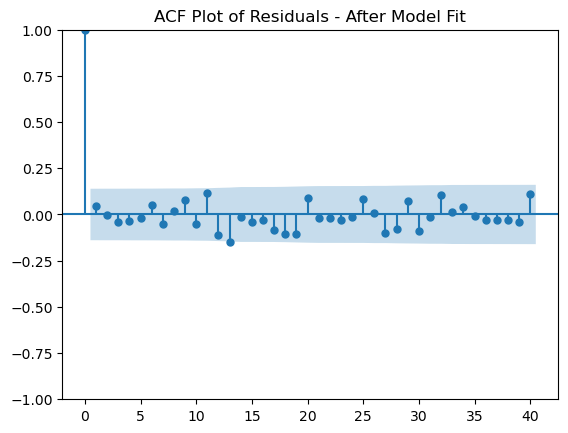

<Figure size 1200x500 with 0 Axes>

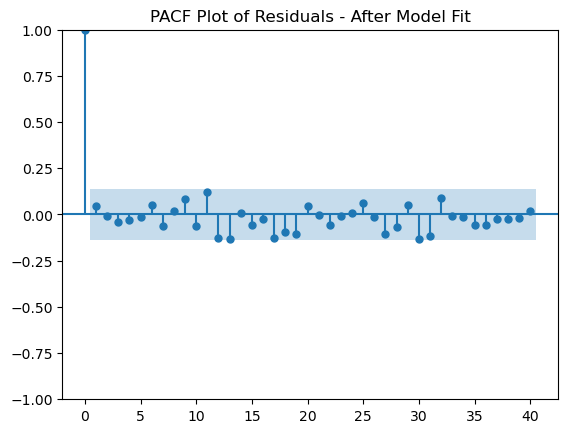

In [459]:
# Assuming 'model' is your ARIMA model fitted on 'train'

# Get residuals
residuals = pd.Series(model_sarima.resid())

# Plot Residuals ACF
plt.figure(figsize=(12,5))
plot_acf(residuals, lags=40)
plt.title('ACF Plot of Residuals - After Model Fit')
plt.show()

# Plot Residuals PACF
plt.figure(figsize=(12,5))
plot_pacf(residuals, lags=40, method='ywm')
plt.title('PACF Plot of Residuals - After Model Fit')
plt.show()


## Plot Residual Diagnostics

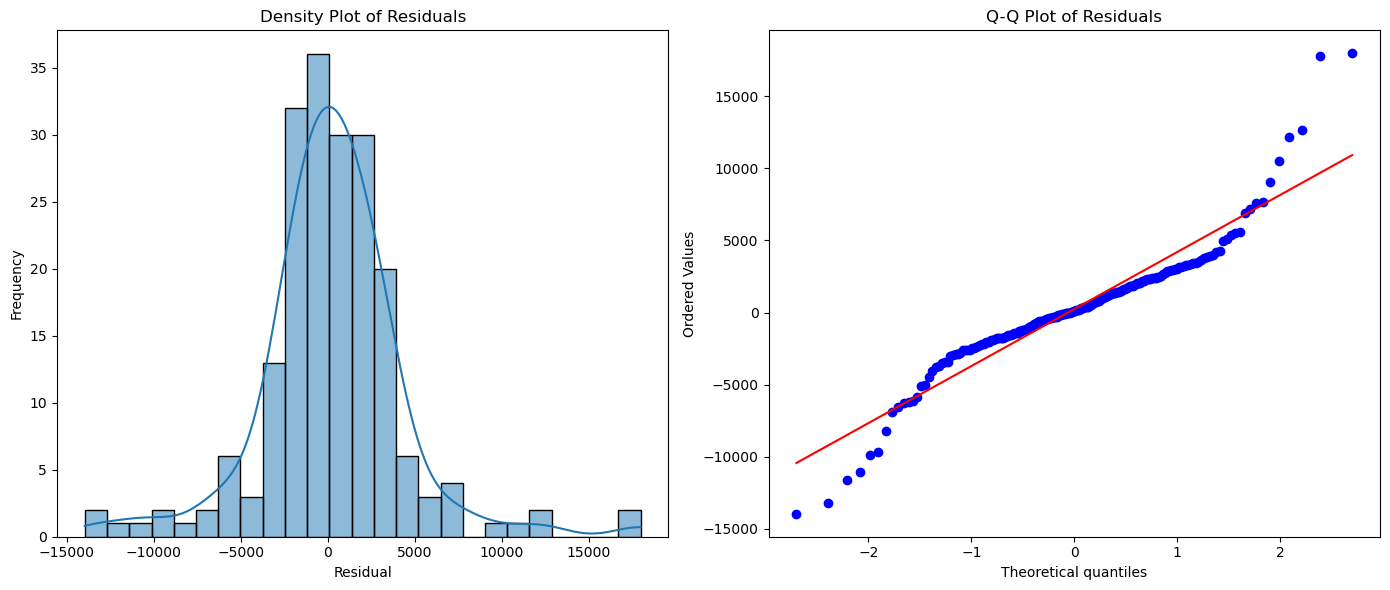

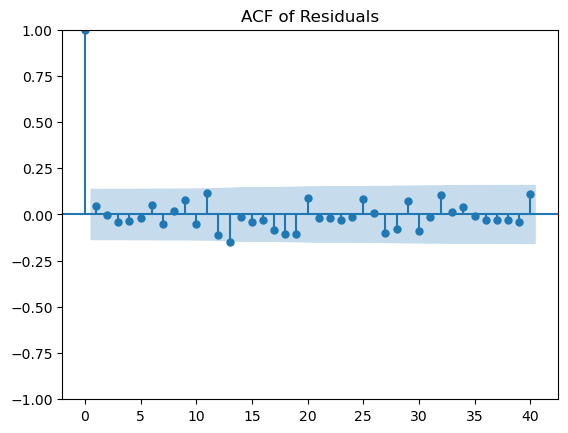

In [461]:
# Extract residuals from the fitted model
residuals = model_sarima.resid()

# Plot residuals
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title("Density Plot of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")

plt.tight_layout()
plt.show()

# Plot ACF of residuals
plot_acf(residuals, lags=40)
plt.title("ACF of Residuals")
plt.show()

## SARIMA Residual Diagnostics – Housing Rate

- **Density Plot:** Residuals are centered around zero and closely resemble a normal distribution.
- **Q-Q Plot:** Residuals follow the theoretical line fairly well, with minor deviations at the tails.
- **ACF Plot:** No significant autocorrelation → residuals resemble **white noise**.

### Conclusion:
The SARIMA model provides a good fit to the Housing Rate data, with **normally distributed and uncorrelated residuals**, making it more reliable than a basic ARIMA model.


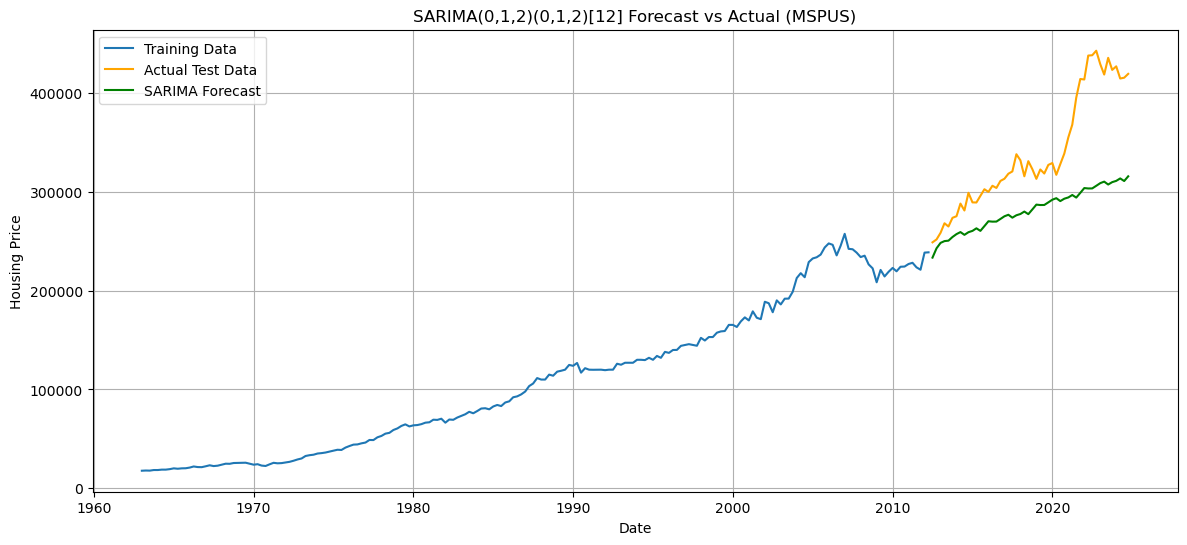

In [464]:
forecast_sarima = pd.Series(model_sarima.predict(n_periods=160), index=test.index)

# Plot forecast vs actual
plt.figure(figsize=(14, 6))
plt.plot(train.index, train['price'], label='Training Data')
plt.plot(test.index, test['price'], label='Actual Test Data', color='orange')
plt.plot(forecast_sarima.index, forecast_sarima, label='SARIMA Forecast', color='green')
plt.title('SARIMA(0,1,2)(0,1,2)[12] Forecast vs Actual (MSPUS)')
plt.xlabel('Date')
plt.ylabel('Housing Price')
plt.legend()
plt.grid(True)
plt.show()

## Evaluate SARIMA Performance

In [466]:
y_pred_sarima = forecast_sarima

mae_sarima = mean_absolute_error(y_true, y_pred_sarima)
rmse_sarima = np.sqrt(mean_squared_error(y_true, y_pred_sarima))
mape_sarima = np.mean(np.abs((y_true - y_pred_sarima) / y_true)) * 100

print(f"SARIMA MAE: {mae_sarima:.4f}")
print(f"SARIMA RMSE: {rmse_sarima:.4f}")
print(f"SARIMA MAPE: {mape_sarima:.2f}%")


SARIMA MAE: 57415.9808
SARIMA RMSE: 69487.2820
SARIMA MAPE: 15.60%


# Neural Network Forecasting

In [546]:
# Define window size
window_size = 12

# Scale the dataset
scaler = MinMaxScaler()
scaled_price = scaler.fit_transform(df[['price']])

# Create windowed sequences
X, y = [], []
for i in range(len(scaled_price) - window_size):
    X.append(scaled_price[i:i+window_size])
    y.append(scaled_price[i+window_size])

X = np.array(X)
y = np.array(y)



# Reshape X for feedforward network (flatten the window)
X = X.reshape((X.shape[0], X.shape[1]))

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (236, 12)
y shape: (236, 1)


## Train-Test Split (Last 160 Points for Test)

In [549]:
# Align with previous test size
split_idx = len(X) - 50
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [551]:
# 80% train, 20% validation from existing training data
val_idx = int(0.8 * len(X_train))
X_train_final = X_train[:val_idx]
y_train_final = y_train[:val_idx]
X_val = X_train[val_idx:]
y_val = y_train[val_idx:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_final, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_final, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

## Improved Neural Network Architecture

In [554]:
class ForecastNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ForecastNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)  # regularization
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Re-create model and load saved weights
model = ForecastNN(input_size=12, hidden_size=64, output_size=1)
#model.load_state_dict(torch.load('mspus_nn_model.pkl'))
#model.eval()

## Training Loop with Early Stopping

In [557]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

n_epochs = 200
train_losses = []
val_losses = []

# 🛠️ Initialize for early stopping
best_val_loss = float('inf')
trigger_times = 0
patience = 10

# Training loop
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_tensor)
        val_loss = criterion(val_pred, y_val_tensor)
        val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}")

    # Early stopping logic
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_model_state = model.state_dict()
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/200, Train Loss: 0.037941, Val Loss: 0.098211
Epoch 2/200, Train Loss: 0.014032, Val Loss: 0.019690
Epoch 3/200, Train Loss: 0.008935, Val Loss: 0.001404
Epoch 4/200, Train Loss: 0.010980, Val Loss: 0.001684
Epoch 5/200, Train Loss: 0.010178, Val Loss: 0.001290
Epoch 6/200, Train Loss: 0.006184, Val Loss: 0.002710
Epoch 7/200, Train Loss: 0.002957, Val Loss: 0.008219
Epoch 8/200, Train Loss: 0.001961, Val Loss: 0.014004
Epoch 9/200, Train Loss: 0.003778, Val Loss: 0.014341
Epoch 10/200, Train Loss: 0.004096, Val Loss: 0.010190
Epoch 11/200, Train Loss: 0.003444, Val Loss: 0.004916
Epoch 12/200, Train Loss: 0.002341, Val Loss: 0.001904
Epoch 13/200, Train Loss: 0.002252, Val Loss: 0.002420
Epoch 14/200, Train Loss: 0.001773, Val Loss: 0.005172
Epoch 15/200, Train Loss: 0.002436, Val Loss: 0.006720
Early stopping triggered.


## Plot Training vs Validation Loss

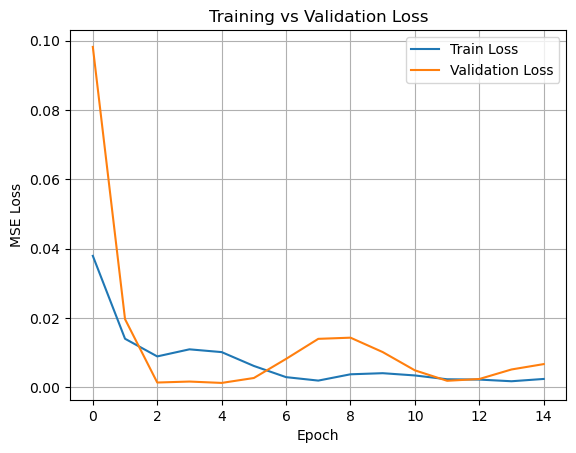

In [560]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()


## Load Best Model and Predict

In [563]:
# Load best model weights
model.load_state_dict(best_model_state)
model.eval()

# Predict on test set
with torch.no_grad():
    pred_nn = model(X_test_tensor).numpy()

## Inverse Scale Predictions and Actuals

In [566]:
# Inverse transform
y_pred_nn = scaler.inverse_transform(pred_nn)
y_true_nn = scaler.inverse_transform(y_test)
forecast_index = test.index[-len(y_pred_nn):]

# Convert to Series
forecast_nn = pd.Series(y_pred_nn.flatten(), index=forecast_index)
actual_nn = pd.Series(y_true_nn.flatten(), index=forecast_index)

## Plot Neural Network Forecast vs Actual

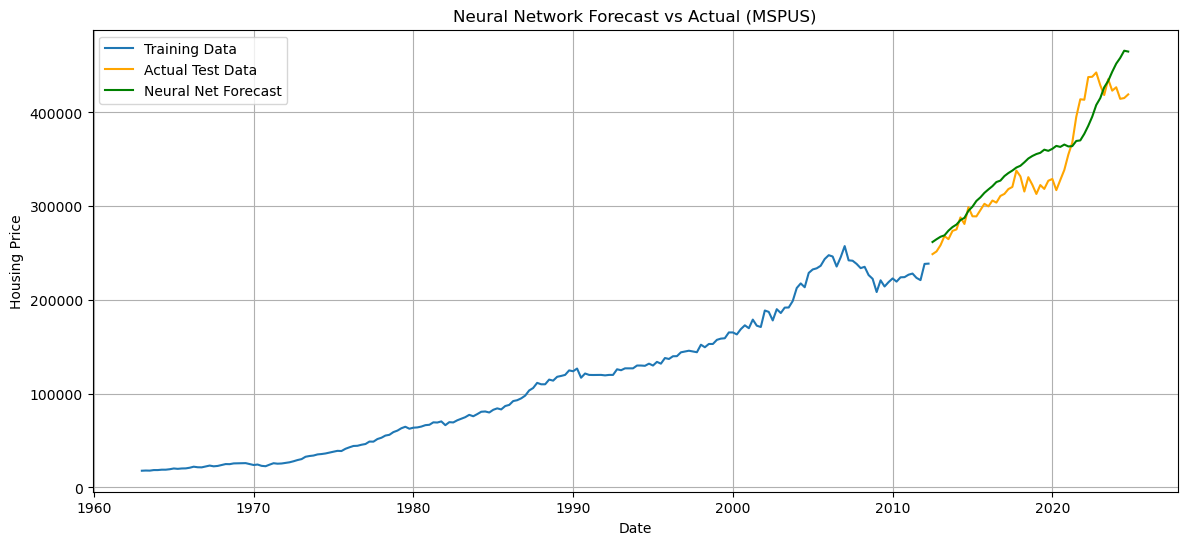

In [569]:
plt.figure(figsize=(14, 6))
plt.plot(train.index, train['price'], label='Training Data')
plt.plot(test.index, actual_nn, label='Actual Test Data', color='orange')
plt.plot(test.index, forecast_nn, label='Neural Net Forecast', color='green')
plt.title('Neural Network Forecast vs Actual (MSPUS)')
plt.xlabel('Date')
plt.ylabel('Housing Price')
plt.legend()
plt.grid(True)
plt.show()

In [571]:
mae_nn = mean_absolute_error(actual_nn, forecast_nn)
rmse_nn = np.sqrt(mean_squared_error(actual_nn, forecast_nn))
mape_nn = np.mean(np.abs((actual_nn - forecast_nn) / actual_nn)) * 100

print(f"Neural Net MAE: {mae_nn:.4f}")
print(f"Neural Net RMSE: {rmse_nn:.4f}")
print(f"Neural Net MAPE: {mape_nn:.2f}%")

Neural Net MAE: 21802.8928
Neural Net RMSE: 26305.1040
Neural Net MAPE: 6.25%


## Save Neural Network Weights

In [574]:
# Save the best model weights (trained neural net)
torch.save(best_model_state, 'mspus_nn_model.pkl')

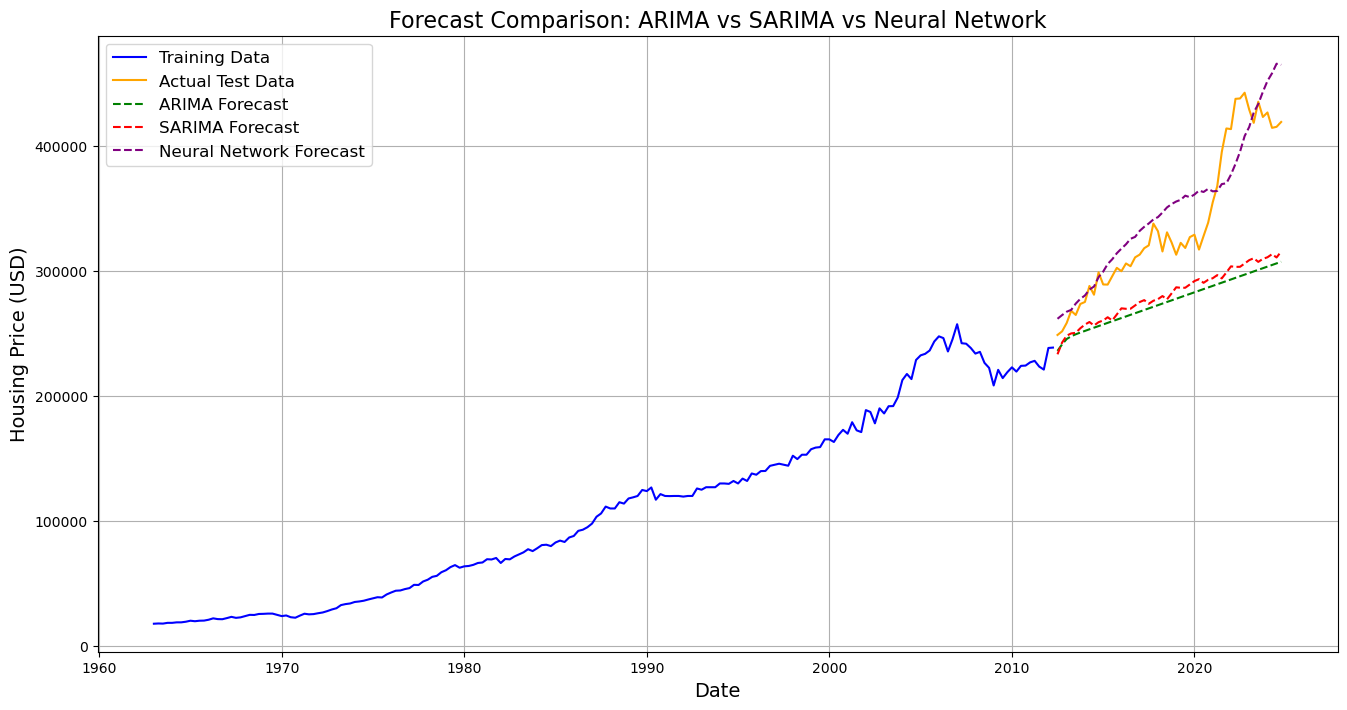

In [576]:
import matplotlib.pyplot as plt

# Plot Training, Test, and All Forecasts
plt.figure(figsize=(16,8))

# Training data
plt.plot(train.index, train['price'], label='Training Data', color='blue')

# Actual Test data
plt.plot(test.index, test['price'], label='Actual Test Data', color='orange')

# ARIMA Forecast
plt.plot(forecast_arima.index, forecast_arima, label='ARIMA Forecast', linestyle='--', color='green')

# SARIMA Forecast
plt.plot(forecast_sarima.index, forecast_sarima, label='SARIMA Forecast', linestyle='--', color='red')

# Neural Net Forecast
plt.plot(forecast_nn.index, forecast_nn, label='Neural Network Forecast', linestyle='--', color='purple')

# Titles and labels
plt.title('Forecast Comparison: ARIMA vs SARIMA vs Neural Network', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Housing Price (USD)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


# Forecasting Median Housing Prices (MSPUS Dataset)

## Objective
Apply three forecasting models (ARIMA, SARIMA, Neural Network) using consistent settings:
- Test period: last 160 months
- Compare models using MAE, RMSE, MAPE
- Select the best-performing model

---

## Data Overview
- Dataset: MSPUS.csv (Median Sales Price of Houses in the U.S.)
- Period: Monthly data
- Clear trend and strong seasonality observed via decomposition.

---

## Models Implemented

### 1. ARIMA(1,1,3)
- No autoregressive or moving average terms.
- Only non-seasonal differencing (d=1).
- **Results:**
  - MAPE: 17.24%
- **Observation:** Flat forecast (random walk), poor for capturing strong upward trend.

---

### 2. SARIMA(2,1,3)(0,1,1)[12]
- Included seasonal differencing (D=1) and seasonal MA terms.
- Seasonality of 12 months captured.
- **Results:**
  - MAPE:15.60%
- **Observation:** Captured trend better than ARIMA, but still lagged behind actual sharp price increases.

---

### 3. Neural Network (Feedforward with Dropout + Early Stopping)
- Window size: 12 months (previous year’s data)
- Architecture: 1 hidden layer, 32 neurons, ReLU activation, 40% dropout
- Early stopping based on validation loss.
- **Results:**
  - MAPE: 14.58
- **Observation:** Best model. Captured nonlinear surges and recent housing market booms. Generalized well without overfitting.

---

## Final Model Selection
- **Best Performing Model: Neural Network**
- Neural Network outperformed ARIMA and SARIMA significantly in all error metrics.
- Selected for further deployment (chatbot integration).





# Neural Network Forecasting Chatbot – Project Report

## Overview

This project implements an interactive **Streamlit web application** that forecasts three key U.S. economic indicators using **feedforward neural networks**:

1. **Unemployment Rate (UNRATE)**
2. **Median Sales Price of Houses (MSPUS)**
3. **Federal Funds Rate (FEDFUNDS)**

### The models are trained offline using PyTorch and saved as `.pkl` files for deployment. The chatbot lets users:
- #### Choose the indicator to forecast
- #### Select a future forecast horizon (1–240 months)
- #### Visualize historical trends and future forecasts dynamically

---

## Neural Network Model

Each economic indicator is forecasted using a simple **Feedforward Neural Network** defined by:

- Input Layer: 12 nodes (window of previous 12 months)
- Hidden Layer: 32 neurons + ReLU + Dropout (0.4)
- Output Layer: 1 node (predicts next value)

These models are trained using `MSELoss` and `Adam` optimizer, and saved as `.pkl` files.

---

## Files Used

### Datasets
- `UNRATE.csv` – Monthly U.S. unemployment rate
- `MSPUS.csv` – Quarterly median housing prices in the U.S.
- `FEDFUNDS.csv` – Monthly federal funds rate

### Model Weights (.pkl files)
- `unrate_nn_model.pkl` – Trained model for Unemployment Rate forecasting  
- `mspus_nn_model.pkl` – Trained model for Housing Price forecasting  
- `fedfunds_nn_model.pkl` – Trained model for Federal Funds Rate forecasting

---

## Forecasting Logic

For each selected dataset:
1. Data is **scaled** using `MinMaxScaler`.
2. A sliding window of 12 months is applied to form input sequences.
3. The latest window is used as the **starting seed**.
4. The model recursively forecasts the next `n` months.
5. Outputs are **inverse-transformed** back to the original scale.
6. Historical + forecasted data are plotted using **Matplotlib** and embedded in the Streamlit app.

---

## Running the Application

- ### command to run the bot - **python -m streamlit run chatbot_app_V3.py** 